# Biliotecas utilizadas

In [1]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from numpy import linalg as LA

# Baixando e tratando os dados das ações

In [3]:
stock_list = ['EGIE3', 'TAEE11', 'ENGI3', 'TRPL3', 'EQTL3', 'ALUP11', 'ELET3']
stock_list = [stock + '.SA' for stock in stock_list]

final_date = dt.datetime.now()
initial_date = final_date - dt.timedelta(days=300)

prices = yf.download(stock_list, start=initial_date, end=final_date)['Adj Close']

[*********************100%%**********************]  7 of 7 completed


In [4]:
prices

Ticker,ALUP11.SA,EGIE3.SA,ELET3.SA,ENGI3.SA,EQTL3.SA,TAEE11.SA,TRPL3.SA
Date,,,,,,,
2023-07-24,26.475702,42.997639,38.453663,13.759338,33.934639,33.158775,31.384565
2023-07-25,26.908522,42.202793,38.354736,14.117458,33.717995,32.698612,31.393932
2023-07-26,26.908522,42.250107,39.146168,14.239973,33.658909,32.770798,31.393932
2023-07-27,26.972988,41.909454,37.810627,14.013791,33.018814,32.572292,31.309641
2023-07-28,26.945360,42.089241,37.612770,14.230549,33.373329,32.653500,30.850718
...,...,...,...,...,...,...,...
2024-05-13,29.281765,43.910000,37.939999,14.820000,30.549999,34.579411,33.900002
2024-05-14,29.549860,44.230000,38.240002,14.590000,31.120001,35.000000,33.959999
2024-05-15,30.165480,43.959999,38.180000,14.770000,31.549999,35.009998,35.139999


In [5]:
returns = prices.pct_change().dropna()
cov_matrix = returns.cov()
wallet_weights = np.full(len(stock_list), 1/len(stock_list))
n_stocks = len(stock_list)

# Simulação de Monte Carlo

In [6]:
n_sims = 100000
projected_days = 252 * 3
capital = 1000

In [7]:
avg_returns = returns.mean(axis=0).to_numpy()
avg_returns_matrix = avg_returns * np.ones(shape = (projected_days, n_stocks))

In [8]:
L = LA.cholesky(cov_matrix)
L

array([[ 0.0102228 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.00418086,  0.01114311,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.00806165,  0.0033103 ,  0.01463911,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.00694469,  0.00083873,  0.00278564,  0.02360834,  0.        ,
         0.        ,  0.        ],
       [ 0.00661402,  0.00442619,  0.00326317,  0.00160551,  0.00983997,
         0.        ,  0.        ],
       [ 0.0043659 ,  0.00281152,  0.00077089,  0.00067134,  0.00173525,
         0.00621688,  0.        ],
       [ 0.00328206, -0.00070878,  0.00011467, -0.00186914,  0.00069637,
         0.00043192,  0.01511214]])

In [9]:
wallet_returns = np.zeros([projected_days, n_sims])
final_capital = np.zeros(n_sims)

for s in range(n_sims):
  Rpdf = np.random.normal(size=(projected_days, n_stocks))

  sint_returns = avg_returns_matrix + np.inner(Rpdf, L)

  wallet_returns[:, s] = np.cumprod(np.inner(wallet_weights, sint_returns) + 1 ) * capital

  final_capital[s] = wallet_returns[-1, s]

final_capital

array([1211.05246043, 1998.83208593, 1700.12764953, ..., 1366.11709381,
       1476.70999328, 1302.92921425])

# Análise dos resultados

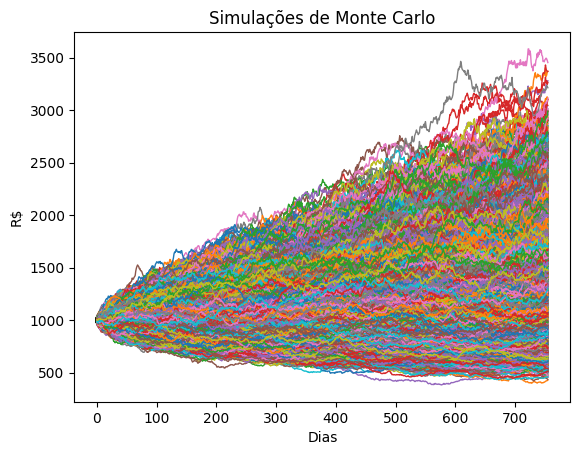

In [34]:
plt.plot(wallet_returns, linewidth=1)
plt.title('Simulações de Monte Carlo')
plt.ylabel('R$')
plt.xlabel('Dias')
plt.show()

In [32]:
montante_99 = str(np.percentile(final_capital, 1))
montante_95 = str(np.percentile(final_capital, 5))
avg_final_capital = str(np.percentile(final_capital, 50))
profitable_sims = str((len(final_capital[final_capital > 1000])/len(final_capital)) * 100) + "%"

print(f'''Em 99% dos casos o montante final é maior que R${round(float(montante_99), 2)}

Em 95% dos casos o montante final é maior que R${round(float(montante_95), 2)}

A média dos retornos finais é de R${round(float(avg_final_capital), 2)}

{profitable_sims} das simulações terminaram com lucro

O maior capital final simulado foi de R${round(max(final_capital), 2)}

O menor capital simulado foi de R${round(min(final_capital), 2)}''')

Em 99% dos casos o montante final é maior que R$692.43
      
Em 95% dos casos o montante final é maior que R$820.52
      
A média dos retornos finais é de R$1224.29
      
79.672% das simulações terminaram com lucro

O maior capital final simulado foi de R$3452.39
      
O menor capital simulado foi de R$430.17


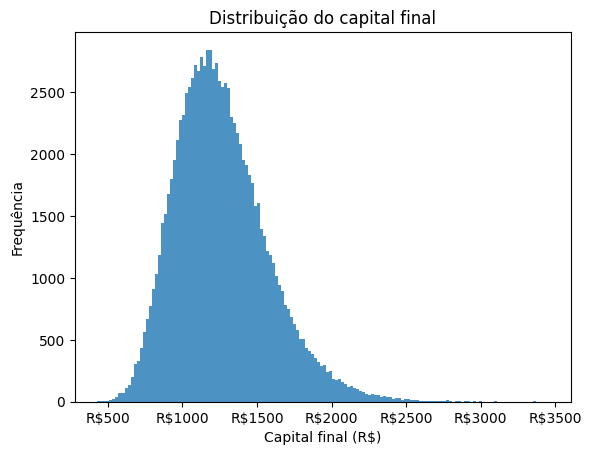

In [33]:
config = dict(histtype = "stepfilled", alpha = 0.8, density = False, bins = 150)
fig, ax = plt.subplots()
ax.hist(final_capital, **config)
ax.xaxis.set_major_formatter('R${x:.0f}')
plt.title('Distribuição do capital final')
plt.xlabel('Capital final (R$)')
plt.ylabel('Frequência')
plt.show()